In [1]:
import sys
sys.path.append("..")

import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import os
from os.path import exists

import pymc as pm
import pytensor
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
from statsmodels.tsa.seasonal import STL

config = {
    'figure.figsize':(14,4),
    'figure.constrained_layout.use':True,
    'figure.facecolor':'w',
    'axes.grid':True,
    'grid.linewidth':0.5,
    'grid.linestyle':'--',
    'axes.spines.top':False,
    'axes.spines.bottom':False,
    'axes.spines.left':False,
    'axes.spines.right':False
}

plt.rcParams.update(config)

SEED = sum(list(map(ord, 'climate_bayes')))
rng = np.random.default_rng(SEED)

In [2]:
from laos_gggi.combine_data import final_data

# Data loading and preparation

In [3]:
#Load data
data = final_data()
df_clim = data["df_time_series"][["co2", "Temp", "precip"]].iloc[1:-1] 
emdat_damage = data["emdat_damage"]["Total_Damage_Adjusted"]
hydro_disasters = data["emdat_events"][["Flood", "Storm"]]
climate_disasters = data["emdat_events"][["Extreme temperature", "Wildfire", "Drought"]]
disasters = data["emdat_events"]
data["emdat_events"][["Drought", "Extreme temperature", "Wildfire"]]
development_indicators = data["wb_data"]
precipitation = data["gpcc"]

In [4]:
#Calculate total climatological and hydrological disasters columns
disasters["climatological_disasters"] = climate_disasters.sum(axis=1)
disasters["hydrological_disasters"] = hydro_disasters.sum(axis = 1)

# Fill NaN values fro disasters and emdat_damage
disasters = disasters.fillna(0)
emdat_damage = emdat_damage.fillna(0)

C:\Users\camil\AppData\Local\Temp\ipykernel_26444\4242024676.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  disasters = disasters.fillna(0)


In [5]:
#Obtain each country's precipitation deviation from the average for its 30-year base climatology period 1961–1990
countries = precipitation.reset_index()["ISO"].unique()
years = precipitation.reset_index()["year"].unique()

precip_deviation = pd.DataFrame()

precip_deviation = pd.DataFrame(columns = countries)
for x in countries:
    precip_deviation[x] = (precipitation.reset_index().pivot(index= "year", values = "precip", columns = "ISO")[x] 
                          -pd.DataFrame(precipitation.unstack(-2).head(30).mean()).loc["precip"].loc[x].values)

precip_deviation = precip_deviation.stack().reset_index().rename(columns = {"level_1": "ISO", 0: "precip_deviation"}).set_index(["ISO", "year"])
precip_deviation = precip_deviation.sort_index()

In [6]:
#Obtain the sea temperature deviation from the trend
stl_ocean_temp = STL( pd.DataFrame(df_clim["Temp"].dropna()), period = 3)
result_ocean_temp = stl_ocean_temp.fit()
trend_ocean_temp = result_ocean_temp.trend
dev_from_trend_ocean_temp = df_clim["Temp"].dropna() - trend_ocean_temp

In [7]:
#Obtain the natural logarithms of population density and GDP per capita
development_indicators["population"] = (development_indicators["SP.POP.TOTL"])
development_indicators["ln_population_density"] = np.log(development_indicators["population_density"])
development_indicators["ln_gdp_pc"] = (development_indicators["gdp_per_cap"]*development_indicators["gdp_per_cap"])
development_indicators["square_ln_gdp_p"] = np.log(development_indicators["ln_gdp_pc"])

In [8]:
#Merging everything into one df
df = pd.merge(disasters, development_indicators, right_index=True, left_index=True, how="left")
df = df.reset_index().rename(columns = {"Start_Year": "year"}).set_index("year")

df = pd.merge(df, pd.DataFrame(dev_from_trend_ocean_temp).rename(columns= {0: "dev_from_trend_ocean_temp"}),
         right_index=True, left_index=True, how="left")

df = pd.merge(df, (df_clim["co2"] ),
         right_index=True, left_index=True, how="left")

df = pd.merge(df.reset_index().set_index(["ISO", "year"]), precip_deviation,
         right_index=True, left_index=True, how="left")

df = df.reset_index()
df = df[['ISO', 'year', 'climatological_disasters','hydrological_disasters',  'population', 'ln_population_density', 'ln_gdp_pc', 'square_ln_gdp_p', 'dev_from_trend_ocean_temp', 'co2', 'precip_deviation']]
df = df.dropna()
df["population"] = df["population"]/1e6

# Model Replication

In [9]:
df

,ISO,year,climatological_disasters,hydrological_disasters,population,ln_population_density,ln_gdp_pc,square_ln_gdp_p,dev_from_trend_ocean_temp,co2,precip_deviation
31,AFG,2000,1.0,0.0,19.542982,3.399974,1.008599e+05,11.521488,0.346101,369.71,-93.972322
32,AFG,2001,2.0,0.0,19.688632,3.407399,8.151150e+04,11.308499,-1.826218,371.32,-115.366493
33,AFG,2002,0.0,2.0,21.000256,3.471893,1.184903e+05,11.682586,-0.346417,373.45,-39.382825
34,AFG,2003,0.0,1.0,22.645130,3.547303,1.206973e+05,11.701041,1.458395,375.98,-6.419823
35,AFG,2004,0.0,2.0,23.553551,3.586635,1.147444e+05,11.650462,0.880218,377.70,-17.836316
...,...,...,...,...,...,...,...,...,...,...,...
8847,ZWE,2016,0.0,1.0,14.452704,3.620600,1.942447e+06,14.479459,-0.979590,404.41,-77.066207
8848,ZWE,2017,1.0,1.0,14.751101,3.641036,2.019925e+06,14.518571,0.165411,406.77,189.574428
8849,ZWE,2018,0.0,0.0,15.052184,3.661241,2.139170e+06,14.575929,0.144035,408.72,105.381606
8850,ZWE,2019,0.0,1.0,15.354608,3.681134,1.803621e+06,14.405307,0.394709,411.66,-230.683096


## version_1_model_HydroMeteorological

In [10]:
#Set coordinates
ISO_idx, ISO =  pd.factorize(df["ISO"])
obs_idx = df.index

COORDS = {'ISO':ISO, 
          #'Year_vals':df['Start_Year'].cat.categories.values,
          "obs_idx": obs_idx}

In [11]:
#HydroMeteorological Disasters

with pm.Model(coords=COORDS) as version_1_model_HydroMeteorological:
    #Declare data
    ln_pop_density = pm.Data("ln_pop_density", df["ln_population_density"], dims=["obs_idx"])
    ln_gdp_pc = pm.Data("ln_gdp_pc", df["ln_gdp_pc"], dims=["obs_idx"])
    square_ln_gdp_p = pm.Data("square_ln_gdp_p", df["square_ln_gdp_p"], dims=["obs_idx"])
    precip_deviation = pm.Data("precip_deviation", df["precip_deviation"], dims=["obs_idx"] )
    co2 = pm.Data("co2", df["co2"], dims=["obs_idx"])
    dev_from_trend_ocean_temp = pm.Data("dev_from_trend_ocean_temp", df["dev_from_trend_ocean_temp"], dims=["obs_idx"])
    population = pm.Data("population", df["population"],dims=["obs_idx"] )

    #Country effect
    country_effect_mu = pm.Normal('country_effect_mu', mu = 0, sigma = 1)
    country_effect_scale = pm.Gamma('country_effect_scale', alpha=2, beta=1)
    country_effect_offset = pm.Normal('country_effect_offset', sigma=1, dims="ISO")
    country_effect = pm.Deterministic('country_effect', country_effect_mu + country_effect_scale * country_effect_offset, dims="ISO")

   # b2 = pm.Normal("Year", mu=0, sigma=1, dims="Year_vals")
    ocean_temp_effect = pm.Normal("ocean_temp_effect", mu=0, sigma=1/10)
    co2_effect = pm.Normal("co2_effect", mu=0, sigma=1/10)
    precip_deviation_effect = pm.Normal("precip_deviation_effect",  mu=0, sigma=1/10 )
    
    #Development indicators: 
    gdp_pc_effect = pm.Normal("gdp_pc_effect", mu=0, sigma=1)
    gdp_pc_squared_effect = pm.Normal("gdp_pc_squared_effect", mu=0, sigma=1)
    pop_density_effect = pm.Normal("pop_density_effect", mu=0, sigma=1)

    #Model mu
    mu = pm.invlogit(country_effect[ISO_idx] + gdp_pc_effect*ln_gdp_pc + gdp_pc_squared_effect*square_ln_gdp_p + pop_density_effect*ln_pop_density
          +precip_deviation_effect*precip_deviation
          + ocean_temp_effect*dev_from_trend_ocean_temp + co2_effect*co2 
          )
    

    # Priors on psi and alpha
    psi = pm.Beta('psi', alpha=2, beta=5)
    alpha = pm.HalfNormal("alpha", sigma = 1)

    y_hat = pm.ZeroInflatedNegativeBinomial("y_hat", mu=(mu), psi = psi , alpha = alpha , observed= df["hydrological_disasters"] , dims = ["obs_idx"])

In [12]:
with version_1_model_HydroMeteorological:
    prior_idata = pm.sample_prior_predictive( )

prior_idata.prior_predictive =  prior_idata.prior_predictive.assign_coords({"obs_idx":obs_idx})

Sampling: [alpha, co2_effect, country_effect_mu, country_effect_offset, country_effect_scale, gdp_pc_effect, gdp_pc_squared_effect, ocean_temp_effect, pop_density_effect, precip_deviation_effect, psi, y_hat]


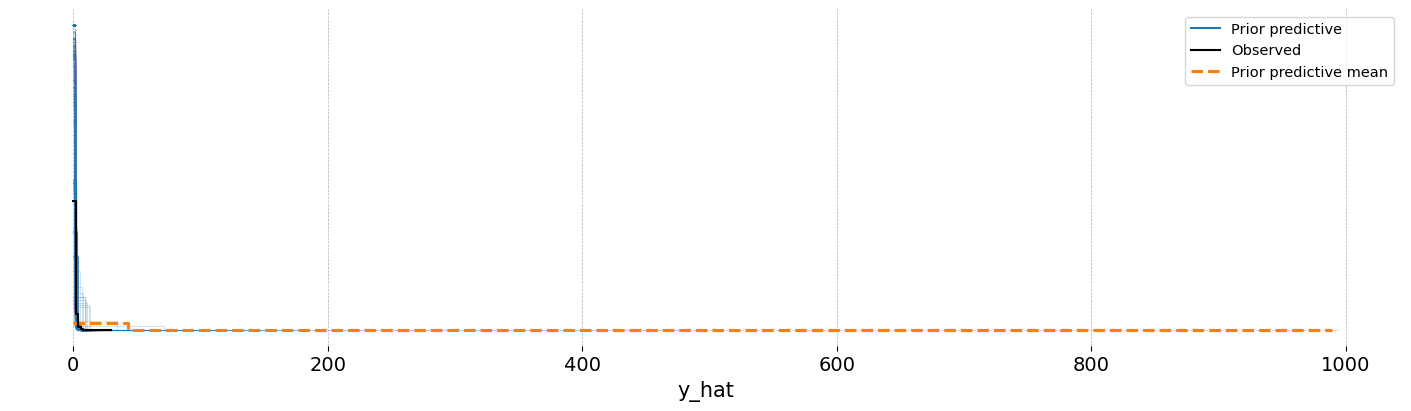

In [13]:
az.plot_ppc(prior_idata, group = "prior", observed = prior_idata.observed_data );

In [14]:
#HydroMeteorological Disasters

with pm.Model(coords=COORDS) as version_1_model_HydroMeteorological:
    #Declare data
    ln_pop_density = pm.Data("ln_pop_density", df["ln_population_density"], dims=["obs_idx"])
    ln_gdp_pc = pm.Data("ln_gdp_pc", df["ln_gdp_pc"], dims=["obs_idx"])
    square_ln_gdp_p = pm.Data("square_ln_gdp_p", df["square_ln_gdp_p"], dims=["obs_idx"])
    precip_deviation = pm.Data("precip_deviation", df["precip_deviation"], dims=["obs_idx"] )
    co2 = pm.Data("co2", df["co2"], dims=["obs_idx"])
    dev_from_trend_ocean_temp = pm.Data("dev_from_trend_ocean_temp", df["dev_from_trend_ocean_temp"], dims=["obs_idx"])
    population = pm.Data("population", df["population"],dims=["obs_idx"] )

    #Country effect
    country_effect_mu = pm.Normal('country_effect_mu', mu = 0, sigma = 1/100)
    country_effect_scale = pm.Gamma('country_effect_scale', alpha=2, beta=1)
    country_effect_offset = pm.Normal('country_effect_offset', sigma=1/100, dims="ISO")
    country_effect = pm.Deterministic('country_effect', country_effect_mu + country_effect_scale * country_effect_offset, dims="ISO")

   # b2 = pm.Normal("Year", mu=0, sigma=1, dims="Year_vals")
    ocean_temp_effect = pm.Normal("ocean_temp_effect", mu=0, sigma=1/100)
    co2_effect = pm.Normal("co2_effect", mu=0, sigma=1/100)
    precip_deviation_effect = pm.Normal("precip_deviation_effect",  mu=0, sigma=1/100)
    
    #Development indicators: 
    gdp_pc_effect = pm.Normal("gdp_pc_effect", mu=0, sigma=1/100)
    gdp_pc_squared_effect = pm.Normal("gdp_pc_squared_effect", mu=0, sigma=1/100)
    pop_density_effect = pm.Normal("pop_density_effect", mu=0, sigma=1/100)

    #Model mu
    mu = np.exp(country_effect[ISO_idx] + gdp_pc_effect*ln_gdp_pc + gdp_pc_squared_effect*square_ln_gdp_p + pop_density_effect*ln_pop_density
          +precip_deviation_effect*precip_deviation
          + ocean_temp_effect*dev_from_trend_ocean_temp + co2_effect*co2 
          )
    

    # Priors on psi and alpha
    psi = pm.Beta('psi', alpha=2, beta=5)
    alpha = pm.HalfNormal("alpha", sigma = 1)

    y_hat = pm.ZeroInflatedNegativeBinomial("y_hat", mu=(mu), psi = psi , alpha = alpha , observed= df["hydrological_disasters"] , dims = ["obs_idx"])

In [15]:
with version_1_model_HydroMeteorological:
    prior_idata = pm.sample_prior_predictive( )

prior_idata.prior_predictive =  prior_idata.prior_predictive.assign_coords({"obs_idx":obs_idx})

Sampling: [alpha, co2_effect, country_effect_mu, country_effect_offset, country_effect_scale, gdp_pc_effect, gdp_pc_squared_effect, ocean_temp_effect, pop_density_effect, precip_deviation_effect, psi, y_hat]


ValueError: Domain error in arguments. The `scale` parameter must be positive for all distributions, and many distributions have restrictions on shape parameters. Please see the `scipy.stats.nbinom` documentation for details.
Apply node that caused the error: nbinom_rv{0, (0, 0), int64, True}(RandomGeneratorSharedVariable(<Generator(PCG64) at 0x1C1A05BB300>), MakeVector{dtype='int64'}.0, 4, alpha, Composite{(i13 / (exp((i2 + (i11 * i12) + (i9 * i10) + (i7 * i8) + (i5 * i6) + (i3 * i4) + (i0 * i1))) + i13))}.0)
Toposort index: 34
Inputs types: [RandomGeneratorType, TensorType(int64, shape=(1,)), TensorType(int64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=(None,))]
Inputs shapes: ['No shapes', (1,), (), (), (5861,)]
Inputs strides: ['No strides', (8,), (), (), (8,)]
Inputs values: [Generator(PCG64) at 0x1C1A05BB300, array([5861], dtype=int64), array(4, dtype=int64), array(0.28620473), 'not shown']
Outputs clients: [['output'], [ExpandDims{axis=1}(nbinom_rv{0, (0, 0), int64, True}.out)]]

HINT: Re-running with most PyTensor optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the PyTensor flag 'optimizer=fast_compile'. If that does not work, PyTensor optimizations can be disabled with 'optimizer=None'.
HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.